In [1]:
# Cell 1: Setup
"""
Notebook 4: Advanced Architectures & Techniques
Vision Transformers, ConvNeXt, Ensemble Methods
"""

import sys
sys.path.append('..')
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from src.models.custom_architectures import build_model, EnsembleModel
from src.models.losses import FocalLoss, OrdinalRegressionLoss
from src.data.dataset import create_data_loaders
from src.training.trainer import Trainer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# Load data
train_loader, val_loader, test_loader = create_data_loaders(
    root_dir='../data/processed',
    batch_size=24,  # Smaller batch for ViT
    num_workers=4
)

/home/usama/anaconda3/envs/analysis/lib/python3.12/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.24). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Device: cuda
Train dataset: 4044 samples
Val dataset: 867 samples
Test dataset: 867 samples
Class distribution (train): {0: 1600, 1: 732, 2: 1061, 3: 530, 4: 121}


In [2]:
# Cell 2: Train Vision Transformer
"""
Train Vision Transformer (ViT)
"""

vit_config = {
    'model_type': 'vit',
    'model_name': 'vit_base_patch16_224',
    'num_classes': 5,
    'pretrained': True,
    'use_ordinal': False
}

vit_model = build_model(vit_config).to(device)

# Use Focal Loss for class imbalance
criterion = FocalLoss(gamma=2.0)
optimizer = optim.AdamW(vit_model.parameters(), lr=5e-5, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

train_config = {
    'epochs': 40,
    'use_amp': True,
    'gradient_clip': 1.0,
    'early_stopping_patience': 12,
    'checkpoint_dir': '../models/checkpoints/vit_base'
}

vit_trainer = Trainer(vit_model, criterion, optimizer, scheduler, device, train_config)

print("\n Training Vision Transformer...")
vit_history = vit_trainer.train(train_loader, val_loader)
vit_test_metrics = vit_trainer.test(test_loader)


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]


 Training Vision Transformer...

Starting training for 40 epochs
Device: cuda
Mixed Precision: True


Epoch 1/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:01<00:00, 21.90it/s, loss=0.6288]



Epoch 1 Summary:
Time: 30.34s | LR: 0.000049
Train - Loss: 0.8987 | Acc: 0.3442
Val   - Loss: 0.6288 | Acc: 0.3299 | MAE: 0.8258
Val   - Precision: 0.4056 | Recall: 0.3299 | F1: 0.2889
✓ Saved best model (val_loss: 0.6288)

Epoch 2/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:01<00:00, 22.39it/s, loss=0.5187]



Epoch 2 Summary:
Time: 26.48s | LR: 0.000045
Train - Loss: 0.6409 | Acc: 0.4697
Val   - Loss: 0.5187 | Acc: 0.4533 | MAE: 0.6205
Val   - Precision: 0.5792 | Recall: 0.4533 | F1: 0.4540
✓ Saved best model (val_loss: 0.5187)

Epoch 3/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 15.37it/s, loss=0.4634]



Epoch 3 Summary:
Time: 26.72s | LR: 0.000040
Train - Loss: 0.5698 | Acc: 0.5119
Val   - Loss: 0.4634 | Acc: 0.5732 | MAE: 0.6205
Val   - Precision: 0.5011 | Recall: 0.5732 | F1: 0.4926
✓ Saved best model (val_loss: 0.4634)

Epoch 4/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 15.36it/s, loss=0.4533]



Epoch 4 Summary:
Time: 26.03s | LR: 0.000033
Train - Loss: 0.5321 | Acc: 0.5342
Val   - Loss: 0.4533 | Acc: 0.4913 | MAE: 0.5559
Val   - Precision: 0.5993 | Recall: 0.4913 | F1: 0.4880
✓ Saved best model (val_loss: 0.4533)

Epoch 5/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 15.05it/s, loss=0.5570]



Epoch 5 Summary:
Time: 26.16s | LR: 0.000025
Train - Loss: 0.4893 | Acc: 0.5573
Val   - Loss: 0.5570 | Acc: 0.4002 | MAE: 0.7151
Val   - Precision: 0.5588 | Recall: 0.4002 | F1: 0.3692

Epoch 6/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 15.95it/s, loss=0.3932]



Epoch 6 Summary:
Time: 25.74s | LR: 0.000017
Train - Loss: 0.4690 | Acc: 0.5784
Val   - Loss: 0.3932 | Acc: 0.6286 | MAE: 0.4983
Val   - Precision: 0.5628 | Recall: 0.6286 | F1: 0.5694
✓ Saved best model (val_loss: 0.3932)

Epoch 7/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 15.31it/s, loss=0.4092]



Epoch 7 Summary:
Time: 27.05s | LR: 0.000010
Train - Loss: 0.4359 | Acc: 0.5816
Val   - Loss: 0.4092 | Acc: 0.5144 | MAE: 0.5271
Val   - Precision: 0.6486 | Recall: 0.5144 | F1: 0.5229

Epoch 8/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 16.42it/s, loss=0.3824]



Epoch 8 Summary:
Time: 25.70s | LR: 0.000005
Train - Loss: 0.3975 | Acc: 0.6121
Val   - Loss: 0.3824 | Acc: 0.5536 | MAE: 0.4740
Val   - Precision: 0.6619 | Recall: 0.5536 | F1: 0.5698
✓ Saved best model (val_loss: 0.3824)

Epoch 9/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:01<00:00, 19.77it/s, loss=0.3556]



Epoch 9 Summary:
Time: 26.86s | LR: 0.000001
Train - Loss: 0.3972 | Acc: 0.6225
Val   - Loss: 0.3556 | Acc: 0.5779 | MAE: 0.4429
Val   - Precision: 0.6784 | Recall: 0.5779 | F1: 0.5993
✓ Saved best model (val_loss: 0.3556)

Epoch 10/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 16.44it/s, loss=0.3469]



Epoch 10 Summary:
Time: 25.75s | LR: 0.000050
Train - Loss: 0.3800 | Acc: 0.6305
Val   - Loss: 0.3469 | Acc: 0.6067 | MAE: 0.4187
Val   - Precision: 0.6843 | Recall: 0.6067 | F1: 0.6254
✓ Saved best model (val_loss: 0.3469)

Epoch 11/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 16.47it/s, loss=0.6557]



Epoch 11 Summary:
Time: 25.84s | LR: 0.000050
Train - Loss: 0.4870 | Acc: 0.5667
Val   - Loss: 0.6557 | Acc: 0.3426 | MAE: 0.7809
Val   - Precision: 0.2390 | Recall: 0.3426 | F1: 0.2679

Epoch 12/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 16.57it/s, loss=0.6246]



Epoch 12 Summary:
Time: 25.50s | LR: 0.000049
Train - Loss: 0.4940 | Acc: 0.5603
Val   - Loss: 0.6246 | Acc: 0.4025 | MAE: 0.7209
Val   - Precision: 0.2732 | Recall: 0.4025 | F1: 0.3182

Epoch 13/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 15.61it/s, loss=0.3968]



Epoch 13 Summary:
Time: 26.36s | LR: 0.000047
Train - Loss: 0.4798 | Acc: 0.5660
Val   - Loss: 0.3968 | Acc: 0.6044 | MAE: 0.4579
Val   - Precision: 0.6369 | Recall: 0.6044 | F1: 0.6076

Epoch 14/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 15.79it/s, loss=0.3954]



Epoch 14 Summary:
Time: 26.59s | LR: 0.000045
Train - Loss: 0.4741 | Acc: 0.5709
Val   - Loss: 0.3954 | Acc: 0.5444 | MAE: 0.4810
Val   - Precision: 0.6732 | Recall: 0.5444 | F1: 0.5725

Epoch 15/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 15.50it/s, loss=0.4309]



Epoch 15 Summary:
Time: 26.67s | LR: 0.000043
Train - Loss: 0.4518 | Acc: 0.5813
Val   - Loss: 0.4309 | Acc: 0.5732 | MAE: 0.5167
Val   - Precision: 0.6108 | Recall: 0.5732 | F1: 0.5835

Epoch 16/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 16.00it/s, loss=0.4363]



Epoch 16 Summary:
Time: 26.58s | LR: 0.000040
Train - Loss: 0.4450 | Acc: 0.5888
Val   - Loss: 0.4363 | Acc: 0.5525 | MAE: 0.5156
Val   - Precision: 0.6385 | Recall: 0.5525 | F1: 0.5390

Epoch 17/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 15.84it/s, loss=0.3478]



Epoch 17 Summary:
Time: 25.53s | LR: 0.000036
Train - Loss: 0.4419 | Acc: 0.5910
Val   - Loss: 0.3478 | Acc: 0.6505 | MAE: 0.4637
Val   - Precision: 0.5864 | Recall: 0.6505 | F1: 0.5951

Epoch 18/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 15.83it/s, loss=0.3876]



Epoch 18 Summary:
Time: 26.12s | LR: 0.000033
Train - Loss: 0.4267 | Acc: 0.5987
Val   - Loss: 0.3876 | Acc: 0.5571 | MAE: 0.4960
Val   - Precision: 0.6374 | Recall: 0.5571 | F1: 0.5750

Epoch 19/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 16.01it/s, loss=0.4073]



Epoch 19 Summary:
Time: 26.27s | LR: 0.000029
Train - Loss: 0.4037 | Acc: 0.6186
Val   - Loss: 0.4073 | Acc: 0.5040 | MAE: 0.5213
Val   - Precision: 0.6883 | Recall: 0.5040 | F1: 0.5094

Epoch 20/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 16.30it/s, loss=0.3650]



Epoch 20 Summary:
Time: 26.46s | LR: 0.000025
Train - Loss: 0.3902 | Acc: 0.6193
Val   - Loss: 0.3650 | Acc: 0.5767 | MAE: 0.4544
Val   - Precision: 0.6758 | Recall: 0.5767 | F1: 0.5985

Epoch 21/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 16.04it/s, loss=0.3359]



Epoch 21 Summary:
Time: 26.39s | LR: 0.000021
Train - Loss: 0.3881 | Acc: 0.6277
Val   - Loss: 0.3359 | Acc: 0.6621 | MAE: 0.3956
Val   - Precision: 0.6625 | Recall: 0.6621 | F1: 0.6603
✓ Saved best model (val_loss: 0.3359)

Epoch 22/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:01<00:00, 23.50it/s, loss=0.4283]



Epoch 22 Summary:
Time: 26.54s | LR: 0.000017
Train - Loss: 0.3836 | Acc: 0.6265
Val   - Loss: 0.4283 | Acc: 0.5121 | MAE: 0.5294
Val   - Precision: 0.6664 | Recall: 0.5121 | F1: 0.5158

Epoch 23/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 16.96it/s, loss=0.3228]



Epoch 23 Summary:
Time: 27.18s | LR: 0.000014
Train - Loss: 0.3684 | Acc: 0.6389
Val   - Loss: 0.3228 | Acc: 0.6482 | MAE: 0.3933
Val   - Precision: 0.6666 | Recall: 0.6482 | F1: 0.6541
✓ Saved best model (val_loss: 0.3228)

Epoch 24/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 16.02it/s, loss=0.3222]



Epoch 24 Summary:
Time: 26.53s | LR: 0.000010
Train - Loss: 0.3553 | Acc: 0.6525
Val   - Loss: 0.3222 | Acc: 0.6621 | MAE: 0.4095
Val   - Precision: 0.6209 | Recall: 0.6621 | F1: 0.6337
✓ Saved best model (val_loss: 0.3222)

Epoch 25/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 16.52it/s, loss=0.3336]



Epoch 25 Summary:
Time: 25.81s | LR: 0.000007
Train - Loss: 0.3408 | Acc: 0.6555
Val   - Loss: 0.3336 | Acc: 0.5998 | MAE: 0.4245
Val   - Precision: 0.6999 | Recall: 0.5998 | F1: 0.6198

Epoch 26/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 15.82it/s, loss=0.3359]



Epoch 26 Summary:
Time: 26.17s | LR: 0.000005
Train - Loss: 0.3325 | Acc: 0.6691
Val   - Loss: 0.3359 | Acc: 0.6332 | MAE: 0.4014
Val   - Precision: 0.6977 | Recall: 0.6332 | F1: 0.6487

Epoch 27/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 15.75it/s, loss=0.3124]



Epoch 27 Summary:
Time: 26.91s | LR: 0.000003
Train - Loss: 0.3240 | Acc: 0.6709
Val   - Loss: 0.3124 | Acc: 0.6678 | MAE: 0.3725
Val   - Precision: 0.6942 | Recall: 0.6678 | F1: 0.6731
✓ Saved best model (val_loss: 0.3124)

Epoch 28/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 15.56it/s, loss=0.3366]



Epoch 28 Summary:
Time: 26.92s | LR: 0.000001
Train - Loss: 0.3154 | Acc: 0.6734
Val   - Loss: 0.3366 | Acc: 0.6194 | MAE: 0.4095
Val   - Precision: 0.6981 | Recall: 0.6194 | F1: 0.6383

Epoch 29/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 15.31it/s, loss=0.3327]



Epoch 29 Summary:
Time: 27.02s | LR: 0.000000
Train - Loss: 0.3282 | Acc: 0.6726
Val   - Loss: 0.3327 | Acc: 0.6309 | MAE: 0.4014
Val   - Precision: 0.6921 | Recall: 0.6309 | F1: 0.6470

Epoch 30/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 15.76it/s, loss=0.3214]



Epoch 30 Summary:
Time: 27.67s | LR: 0.000050
Train - Loss: 0.3099 | Acc: 0.6823
Val   - Loss: 0.3214 | Acc: 0.6459 | MAE: 0.3841
Val   - Precision: 0.7022 | Recall: 0.6459 | F1: 0.6615

Epoch 31/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:01<00:00, 20.93it/s, loss=0.4081]



Epoch 31 Summary:
Time: 26.78s | LR: 0.000050
Train - Loss: 0.4012 | Acc: 0.6233
Val   - Loss: 0.4081 | Acc: 0.5606 | MAE: 0.4637
Val   - Precision: 0.6682 | Recall: 0.5606 | F1: 0.5854

Epoch 32/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 18.47it/s, loss=0.3635]



Epoch 32 Summary:
Time: 27.23s | LR: 0.000050
Train - Loss: 0.4218 | Acc: 0.6148
Val   - Loss: 0.3635 | Acc: 0.6021 | MAE: 0.4406
Val   - Precision: 0.6386 | Recall: 0.6021 | F1: 0.6142

Epoch 33/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 15.23it/s, loss=0.3805]



Epoch 33 Summary:
Time: 27.00s | LR: 0.000049
Train - Loss: 0.4136 | Acc: 0.6171
Val   - Loss: 0.3805 | Acc: 0.6009 | MAE: 0.4833
Val   - Precision: 0.6435 | Recall: 0.6009 | F1: 0.5756

Epoch 34/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:01<00:00, 23.01it/s, loss=0.4108]



Epoch 34 Summary:
Time: 25.76s | LR: 0.000049
Train - Loss: 0.4230 | Acc: 0.5913
Val   - Loss: 0.4108 | Acc: 0.5928 | MAE: 0.5144
Val   - Precision: 0.6283 | Recall: 0.5928 | F1: 0.5558

Epoch 35/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:01<00:00, 23.68it/s, loss=0.4573]



Epoch 35 Summary:
Time: 17.79s | LR: 0.000048
Train - Loss: 0.4042 | Acc: 0.6136
Val   - Loss: 0.4573 | Acc: 0.4844 | MAE: 0.5467
Val   - Precision: 0.6622 | Recall: 0.4844 | F1: 0.4811

Epoch 36/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:01<00:00, 22.83it/s, loss=0.3810]



Epoch 36 Summary:
Time: 16.10s | LR: 0.000047
Train - Loss: 0.3997 | Acc: 0.6156
Val   - Loss: 0.3810 | Acc: 0.6021 | MAE: 0.4544
Val   - Precision: 0.6434 | Recall: 0.6021 | F1: 0.5928

Epoch 37/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:01<00:00, 22.03it/s, loss=0.3489]



Epoch 37 Summary:
Time: 16.16s | LR: 0.000046
Train - Loss: 0.4032 | Acc: 0.6138
Val   - Loss: 0.3489 | Acc: 0.6436 | MAE: 0.4221
Val   - Precision: 0.6322 | Recall: 0.6436 | F1: 0.6354

Epoch 38/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:01<00:00, 23.18it/s, loss=0.3528]



Epoch 38 Summary:
Time: 16.02s | LR: 0.000045
Train - Loss: 0.4037 | Acc: 0.6156
Val   - Loss: 0.3528 | Acc: 0.6574 | MAE: 0.4037
Val   - Precision: 0.6621 | Recall: 0.6574 | F1: 0.6583

Epoch 39/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:01<00:00, 22.03it/s, loss=0.4888]



Epoch 39 Summary:
Time: 16.01s | LR: 0.000044
Train - Loss: 0.4063 | Acc: 0.6151
Val   - Loss: 0.4888 | Acc: 0.5905 | MAE: 0.5352
Val   - Precision: 0.5904 | Recall: 0.5905 | F1: 0.5784

⚠ Early stopping triggered at epoch 39

✓ Loaded best model weights

Evaluating on test set...


Validation: 100%|██████████| 37/37 [00:01<00:00, 23.63it/s, loss=0.3738]


Test Set Results:
Accuracy: 0.6482
MAE: 0.4037
Precision: 0.6824
Recall: 0.6482
F1-Score: 0.6587


In [3]:
# Cell 3: Train ConvNeXt
"""
Train ConvNeXt architecture
"""

convnext_config = {
    'model_type': 'convnext',
    'model_name': 'convnext_base',
    'num_classes': 5,
    'pretrained': True,
    'use_ordinal': False
}

convnext_model = build_model(convnext_config).to(device)

criterion = FocalLoss(gamma=2.0)
optimizer = optim.AdamW(convnext_model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40)

train_config['checkpoint_dir'] = '../models/checkpoints/convnext_base'

convnext_trainer = Trainer(convnext_model, criterion, optimizer, scheduler, device, train_config)

print("\n Training ConvNeXt...")
convnext_history = convnext_trainer.train(train_loader, val_loader)
convnext_test_metrics = convnext_trainer.test(test_loader)

model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]


 Training ConvNeXt...

Starting training for 40 epochs
Device: cuda
Mixed Precision: True


Epoch 1/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 18.08it/s, loss=0.5373]



Epoch 1 Summary:
Time: 22.06s | LR: 0.000100
Train - Loss: 0.8541 | Acc: 0.3435
Val   - Loss: 0.5373 | Acc: 0.4129 | MAE: 0.6482
Val   - Precision: 0.6046 | Recall: 0.4129 | F1: 0.4171
✓ Saved best model (val_loss: 0.5373)

Epoch 2/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 17.80it/s, loss=0.4265]



Epoch 2 Summary:
Time: 22.23s | LR: 0.000099
Train - Loss: 0.5473 | Acc: 0.5409
Val   - Loss: 0.4265 | Acc: 0.4902 | MAE: 0.5248
Val   - Precision: 0.6826 | Recall: 0.4902 | F1: 0.5047
✓ Saved best model (val_loss: 0.4265)

Epoch 3/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 17.45it/s, loss=0.3262]



Epoch 3 Summary:
Time: 22.06s | LR: 0.000099
Train - Loss: 0.4562 | Acc: 0.5843
Val   - Loss: 0.3262 | Acc: 0.6609 | MAE: 0.3945
Val   - Precision: 0.6428 | Recall: 0.6609 | F1: 0.6485
✓ Saved best model (val_loss: 0.3262)

Epoch 4/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 17.78it/s, loss=0.4531]



Epoch 4 Summary:
Time: 22.26s | LR: 0.000098
Train - Loss: 0.4428 | Acc: 0.5888
Val   - Loss: 0.4531 | Acc: 0.5836 | MAE: 0.4706
Val   - Precision: 0.6354 | Recall: 0.5836 | F1: 0.5597

Epoch 5/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 18.49it/s, loss=0.3258]



Epoch 5 Summary:
Time: 21.92s | LR: 0.000096
Train - Loss: 0.4226 | Acc: 0.6101
Val   - Loss: 0.3258 | Acc: 0.6517 | MAE: 0.3899
Val   - Precision: 0.6637 | Recall: 0.6517 | F1: 0.6565
✓ Saved best model (val_loss: 0.3258)

Epoch 6/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 16.74it/s, loss=0.3542]



Epoch 6 Summary:
Time: 22.18s | LR: 0.000095
Train - Loss: 0.3841 | Acc: 0.6297
Val   - Loss: 0.3542 | Acc: 0.5963 | MAE: 0.4279
Val   - Precision: 0.7187 | Recall: 0.5963 | F1: 0.6171

Epoch 7/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 18.48it/s, loss=0.3410]



Epoch 7 Summary:
Time: 21.81s | LR: 0.000093
Train - Loss: 0.3910 | Acc: 0.6248
Val   - Loss: 0.3410 | Acc: 0.6205 | MAE: 0.3887
Val   - Precision: 0.7330 | Recall: 0.6205 | F1: 0.6470

Epoch 8/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 17.60it/s, loss=0.3337]



Epoch 8 Summary:
Time: 22.50s | LR: 0.000090
Train - Loss: 0.3715 | Acc: 0.6364
Val   - Loss: 0.3337 | Acc: 0.6367 | MAE: 0.3887
Val   - Precision: 0.6902 | Recall: 0.6367 | F1: 0.6558

Epoch 9/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:01<00:00, 18.77it/s, loss=0.3528]



Epoch 9 Summary:
Time: 21.72s | LR: 0.000088
Train - Loss: 0.3497 | Acc: 0.6612
Val   - Loss: 0.3528 | Acc: 0.6148 | MAE: 0.4014
Val   - Precision: 0.7163 | Recall: 0.6148 | F1: 0.6357

Epoch 10/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 16.30it/s, loss=0.3140]



Epoch 10 Summary:
Time: 22.00s | LR: 0.000085
Train - Loss: 0.3509 | Acc: 0.6533
Val   - Loss: 0.3140 | Acc: 0.6874 | MAE: 0.3610
Val   - Precision: 0.6857 | Recall: 0.6874 | F1: 0.6862
✓ Saved best model (val_loss: 0.3140)

Epoch 11/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 18.18it/s, loss=0.3208]



Epoch 11 Summary:
Time: 21.63s | LR: 0.000082
Train - Loss: 0.3417 | Acc: 0.6632
Val   - Loss: 0.3208 | Acc: 0.6632 | MAE: 0.3564
Val   - Precision: 0.7161 | Recall: 0.6632 | F1: 0.6772

Epoch 12/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 18.09it/s, loss=0.3625]



Epoch 12 Summary:
Time: 22.01s | LR: 0.000079
Train - Loss: 0.3480 | Acc: 0.6523
Val   - Loss: 0.3625 | Acc: 0.6586 | MAE: 0.3818
Val   - Precision: 0.7021 | Recall: 0.6586 | F1: 0.6691

Epoch 13/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 17.64it/s, loss=0.3151]



Epoch 13 Summary:
Time: 22.30s | LR: 0.000076
Train - Loss: 0.3267 | Acc: 0.6793
Val   - Loss: 0.3151 | Acc: 0.6471 | MAE: 0.3772
Val   - Precision: 0.6821 | Recall: 0.6471 | F1: 0.6570

Epoch 14/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 17.96it/s, loss=0.3122]



Epoch 14 Summary:
Time: 21.89s | LR: 0.000073
Train - Loss: 0.3192 | Acc: 0.6820
Val   - Loss: 0.3122 | Acc: 0.6424 | MAE: 0.3772
Val   - Precision: 0.6933 | Recall: 0.6424 | F1: 0.6567
✓ Saved best model (val_loss: 0.3122)

Epoch 15/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:01<00:00, 18.50it/s, loss=0.3582]



Epoch 15 Summary:
Time: 21.75s | LR: 0.000069
Train - Loss: 0.3172 | Acc: 0.6825
Val   - Loss: 0.3582 | Acc: 0.6678 | MAE: 0.4002
Val   - Precision: 0.6509 | Recall: 0.6678 | F1: 0.6494

Epoch 16/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 18.03it/s, loss=0.3481]



Epoch 16 Summary:
Time: 21.76s | LR: 0.000065
Train - Loss: 0.3059 | Acc: 0.6944
Val   - Loss: 0.3481 | Acc: 0.6136 | MAE: 0.4152
Val   - Precision: 0.6933 | Recall: 0.6136 | F1: 0.6289

Epoch 17/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 18.18it/s, loss=0.3292]



Epoch 17 Summary:
Time: 21.83s | LR: 0.000062
Train - Loss: 0.2945 | Acc: 0.7036
Val   - Loss: 0.3292 | Acc: 0.6355 | MAE: 0.3760
Val   - Precision: 0.7153 | Recall: 0.6355 | F1: 0.6563

Epoch 18/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:01<00:00, 18.52it/s, loss=0.3247]



Epoch 18 Summary:
Time: 21.95s | LR: 0.000058
Train - Loss: 0.3036 | Acc: 0.6942
Val   - Loss: 0.3247 | Acc: 0.6528 | MAE: 0.3691
Val   - Precision: 0.6921 | Recall: 0.6528 | F1: 0.6634

Epoch 19/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 18.00it/s, loss=0.3193]



Epoch 19 Summary:
Time: 22.02s | LR: 0.000054
Train - Loss: 0.2922 | Acc: 0.6917
Val   - Loss: 0.3193 | Acc: 0.6609 | MAE: 0.3541
Val   - Precision: 0.7174 | Recall: 0.6609 | F1: 0.6767

Epoch 20/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 18.08it/s, loss=0.3359]



Epoch 20 Summary:
Time: 21.97s | LR: 0.000050
Train - Loss: 0.2841 | Acc: 0.7076
Val   - Loss: 0.3359 | Acc: 0.6471 | MAE: 0.3714
Val   - Precision: 0.7120 | Recall: 0.6471 | F1: 0.6646

Epoch 21/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 15.07it/s, loss=0.3655]



Epoch 21 Summary:
Time: 22.61s | LR: 0.000046
Train - Loss: 0.2731 | Acc: 0.7220
Val   - Loss: 0.3655 | Acc: 0.6459 | MAE: 0.3875
Val   - Precision: 0.6997 | Recall: 0.6459 | F1: 0.6594

Epoch 22/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 17.68it/s, loss=0.3208]



Epoch 22 Summary:
Time: 24.60s | LR: 0.000042
Train - Loss: 0.2756 | Acc: 0.7143
Val   - Loss: 0.3208 | Acc: 0.6436 | MAE: 0.3829
Val   - Precision: 0.6835 | Recall: 0.6436 | F1: 0.6523

Epoch 23/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 17.63it/s, loss=0.3162]



Epoch 23 Summary:
Time: 21.97s | LR: 0.000038
Train - Loss: 0.2687 | Acc: 0.7232
Val   - Loss: 0.3162 | Acc: 0.6655 | MAE: 0.3645
Val   - Precision: 0.6794 | Recall: 0.6655 | F1: 0.6652

Epoch 24/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 17.13it/s, loss=0.3303]



Epoch 24 Summary:
Time: 22.00s | LR: 0.000035
Train - Loss: 0.2597 | Acc: 0.7321
Val   - Loss: 0.3303 | Acc: 0.6505 | MAE: 0.3714
Val   - Precision: 0.6853 | Recall: 0.6505 | F1: 0.6618

Epoch 25/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 17.50it/s, loss=0.3506]



Epoch 25 Summary:
Time: 22.09s | LR: 0.000031
Train - Loss: 0.2518 | Acc: 0.7403
Val   - Loss: 0.3506 | Acc: 0.6632 | MAE: 0.3668
Val   - Precision: 0.6778 | Recall: 0.6632 | F1: 0.6692

Epoch 26/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 18.26it/s, loss=0.4162]



Epoch 26 Summary:
Time: 21.97s | LR: 0.000027
Train - Loss: 0.2401 | Acc: 0.7433
Val   - Loss: 0.4162 | Acc: 0.5767 | MAE: 0.4418
Val   - Precision: 0.7107 | Recall: 0.5767 | F1: 0.5962

⚠ Early stopping triggered at epoch 26

✓ Loaded best model weights

Evaluating on test set...


Validation: 100%|██████████| 37/37 [00:02<00:00, 18.10it/s, loss=0.3405]


Test Set Results:
Accuracy: 0.6436
MAE: 0.3922
Precision: 0.6941
Recall: 0.6436
F1-Score: 0.6573


In [4]:
# Cell 4: Train with Ordinal Loss
"""
Train EfficientNet-B4 with Ordinal Regression Loss
"""

ordinal_config = {
    'model_type': 'efficientnet',
    'model_name': 'efficientnet_b4',
    'num_classes': 5,
    'pretrained': True,
    'use_ordinal': True,
    'use_attention': True
}

ordinal_model = build_model(ordinal_config).to(device)

criterion = OrdinalRegressionLoss(num_classes=5)
optimizer = optim.AdamW(ordinal_model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40)

train_config['checkpoint_dir'] = '../models/checkpoints/efficientnet_ordinal'

ordinal_trainer = Trainer(ordinal_model, criterion, optimizer, scheduler, device, train_config)

print("\n Training with Ordinal Loss...")
ordinal_history = ordinal_trainer.train(train_loader, val_loader)
ordinal_test_metrics = ordinal_trainer.test(test_loader)


 Training with Ordinal Loss...

Starting training for 40 epochs
Device: cuda
Mixed Precision: True


Epoch 1/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 17.47it/s, loss=0.5794]



Epoch 1 Summary:
Time: 25.94s | LR: 0.000100
Train - Loss: 0.6105 | Acc: 0.2011
Val   - Loss: 0.5794 | Acc: 0.3956 | MAE: 1.2180
Val   - Precision: 0.1565 | Recall: 0.3956 | F1: 0.2243
✓ Saved best model (val_loss: 0.5794)

Epoch 2/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:01<00:00, 19.20it/s, loss=0.3389]



Epoch 2 Summary:
Time: 25.53s | LR: 0.000099
Train - Loss: 0.4804 | Acc: 0.2039
Val   - Loss: 0.3389 | Acc: 0.3956 | MAE: 1.2157
Val   - Precision: 0.1569 | Recall: 0.3956 | F1: 0.2247
✓ Saved best model (val_loss: 0.3389)

Epoch 3/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 18.19it/s, loss=0.3037]



Epoch 3 Summary:
Time: 24.87s | LR: 0.000099
Train - Loss: 0.3922 | Acc: 0.1954
Val   - Loss: 0.3037 | Acc: 0.3956 | MAE: 1.2180
Val   - Precision: 0.1565 | Recall: 0.3956 | F1: 0.2243
✓ Saved best model (val_loss: 0.3037)

Epoch 4/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 17.94it/s, loss=0.2850]



Epoch 4 Summary:
Time: 25.02s | LR: 0.000098
Train - Loss: 0.3703 | Acc: 0.2011
Val   - Loss: 0.2850 | Acc: 0.3956 | MAE: 1.2134
Val   - Precision: 0.1572 | Recall: 0.3956 | F1: 0.2250
✓ Saved best model (val_loss: 0.2850)

Epoch 5/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 17.40it/s, loss=0.2665]



Epoch 5 Summary:
Time: 25.05s | LR: 0.000096
Train - Loss: 0.3549 | Acc: 0.2041
Val   - Loss: 0.2665 | Acc: 0.3956 | MAE: 1.2180
Val   - Precision: 0.1565 | Recall: 0.3956 | F1: 0.2243
✓ Saved best model (val_loss: 0.2665)

Epoch 6/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 16.82it/s, loss=0.2636]



Epoch 6 Summary:
Time: 25.19s | LR: 0.000095
Train - Loss: 0.3394 | Acc: 0.1942
Val   - Loss: 0.2636 | Acc: 0.3956 | MAE: 1.2180
Val   - Precision: 0.1565 | Recall: 0.3956 | F1: 0.2243
✓ Saved best model (val_loss: 0.2636)

Epoch 7/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 18.49it/s, loss=0.2582]



Epoch 7 Summary:
Time: 24.90s | LR: 0.000093
Train - Loss: 0.3253 | Acc: 0.1892
Val   - Loss: 0.2582 | Acc: 0.3956 | MAE: 1.2168
Val   - Precision: 0.1567 | Recall: 0.3956 | F1: 0.2245
✓ Saved best model (val_loss: 0.2582)

Epoch 8/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 17.91it/s, loss=0.2480]



Epoch 8 Summary:
Time: 25.01s | LR: 0.000090
Train - Loss: 0.3228 | Acc: 0.1992
Val   - Loss: 0.2480 | Acc: 0.3956 | MAE: 1.2168
Val   - Precision: 0.1567 | Recall: 0.3956 | F1: 0.2245
✓ Saved best model (val_loss: 0.2480)

Epoch 9/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 18.24it/s, loss=0.2404]



Epoch 9 Summary:
Time: 25.07s | LR: 0.000088
Train - Loss: 0.3110 | Acc: 0.1974
Val   - Loss: 0.2404 | Acc: 0.3956 | MAE: 1.2088
Val   - Precision: 0.1580 | Recall: 0.3956 | F1: 0.2258
✓ Saved best model (val_loss: 0.2404)

Epoch 10/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 18.26it/s, loss=0.2320]



Epoch 10 Summary:
Time: 25.37s | LR: 0.000085
Train - Loss: 0.3089 | Acc: 0.1930
Val   - Loss: 0.2320 | Acc: 0.3956 | MAE: 1.2053
Val   - Precision: 0.1585 | Recall: 0.3956 | F1: 0.2263
✓ Saved best model (val_loss: 0.2320)

Epoch 11/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 18.13it/s, loss=0.2242]



Epoch 11 Summary:
Time: 24.90s | LR: 0.000082
Train - Loss: 0.3048 | Acc: 0.2036
Val   - Loss: 0.2242 | Acc: 0.3956 | MAE: 1.2088
Val   - Precision: 0.1580 | Recall: 0.3956 | F1: 0.2258
✓ Saved best model (val_loss: 0.2242)

Epoch 12/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 17.47it/s, loss=0.2517]



Epoch 12 Summary:
Time: 24.58s | LR: 0.000079
Train - Loss: 0.2952 | Acc: 0.1987
Val   - Loss: 0.2517 | Acc: 0.3956 | MAE: 1.2053
Val   - Precision: 0.1585 | Recall: 0.3956 | F1: 0.2263

Epoch 13/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:01<00:00, 18.60it/s, loss=0.2256]



Epoch 13 Summary:
Time: 24.35s | LR: 0.000076
Train - Loss: 0.2948 | Acc: 0.2016
Val   - Loss: 0.2256 | Acc: 0.3956 | MAE: 1.2053
Val   - Precision: 0.1585 | Recall: 0.3956 | F1: 0.2263

Epoch 14/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:01<00:00, 18.99it/s, loss=0.2308]



Epoch 14 Summary:
Time: 24.52s | LR: 0.000073
Train - Loss: 0.2852 | Acc: 0.1902
Val   - Loss: 0.2308 | Acc: 0.3956 | MAE: 1.2076
Val   - Precision: 0.1582 | Recall: 0.3956 | F1: 0.2260

Epoch 15/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:01<00:00, 19.01it/s, loss=0.2199]



Epoch 15 Summary:
Time: 24.54s | LR: 0.000069
Train - Loss: 0.2810 | Acc: 0.2009
Val   - Loss: 0.2199 | Acc: 0.3956 | MAE: 1.2053
Val   - Precision: 0.1585 | Recall: 0.3956 | F1: 0.2263
✓ Saved best model (val_loss: 0.2199)

Epoch 16/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 17.84it/s, loss=0.2166]



Epoch 16 Summary:
Time: 24.60s | LR: 0.000065
Train - Loss: 0.2764 | Acc: 0.2016
Val   - Loss: 0.2166 | Acc: 0.3956 | MAE: 1.2053
Val   - Precision: 0.1585 | Recall: 0.3956 | F1: 0.2263
✓ Saved best model (val_loss: 0.2166)

Epoch 17/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:01<00:00, 19.06it/s, loss=0.2179]



Epoch 17 Summary:
Time: 26.57s | LR: 0.000062
Train - Loss: 0.2708 | Acc: 0.1964
Val   - Loss: 0.2179 | Acc: 0.3956 | MAE: 1.2042
Val   - Precision: 0.1587 | Recall: 0.3956 | F1: 0.2265

Epoch 18/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 17.56it/s, loss=0.2485]



Epoch 18 Summary:
Time: 24.79s | LR: 0.000058
Train - Loss: 0.2797 | Acc: 0.1954
Val   - Loss: 0.2485 | Acc: 0.3956 | MAE: 1.2053
Val   - Precision: 0.1585 | Recall: 0.3956 | F1: 0.2263

Epoch 19/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 17.34it/s, loss=0.2148]



Epoch 19 Summary:
Time: 25.24s | LR: 0.000054
Train - Loss: 0.2609 | Acc: 0.2006
Val   - Loss: 0.2148 | Acc: 0.3956 | MAE: 1.2145
Val   - Precision: 0.1571 | Recall: 0.3956 | F1: 0.2248
✓ Saved best model (val_loss: 0.2148)

Epoch 20/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:01<00:00, 19.37it/s, loss=0.2256]



Epoch 20 Summary:
Time: 24.25s | LR: 0.000050
Train - Loss: 0.2656 | Acc: 0.1930
Val   - Loss: 0.2256 | Acc: 0.3956 | MAE: 1.2157
Val   - Precision: 0.1569 | Recall: 0.3956 | F1: 0.2247

Epoch 21/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:01<00:00, 19.13it/s, loss=0.2336]



Epoch 21 Summary:
Time: 24.38s | LR: 0.000046
Train - Loss: 0.2585 | Acc: 0.1947
Val   - Loss: 0.2336 | Acc: 0.3956 | MAE: 1.2099
Val   - Precision: 0.1578 | Recall: 0.3956 | F1: 0.2256

Epoch 22/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:01<00:00, 18.75it/s, loss=0.2096]



Epoch 22 Summary:
Time: 24.35s | LR: 0.000042
Train - Loss: 0.2610 | Acc: 0.1994
Val   - Loss: 0.2096 | Acc: 0.3956 | MAE: 1.2053
Val   - Precision: 0.1585 | Recall: 0.3956 | F1: 0.2263
✓ Saved best model (val_loss: 0.2096)

Epoch 23/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 18.32it/s, loss=0.2098]



Epoch 23 Summary:
Time: 23.90s | LR: 0.000038
Train - Loss: 0.2666 | Acc: 0.1935
Val   - Loss: 0.2098 | Acc: 0.3956 | MAE: 1.2076
Val   - Precision: 0.1582 | Recall: 0.3956 | F1: 0.2260

Epoch 24/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 18.08it/s, loss=0.2171]



Epoch 24 Summary:
Time: 24.36s | LR: 0.000035
Train - Loss: 0.2579 | Acc: 0.2031
Val   - Loss: 0.2171 | Acc: 0.3956 | MAE: 1.2053
Val   - Precision: 0.1585 | Recall: 0.3956 | F1: 0.2263

Epoch 25/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 18.21it/s, loss=0.2068]



Epoch 25 Summary:
Time: 24.70s | LR: 0.000031
Train - Loss: 0.2530 | Acc: 0.1922
Val   - Loss: 0.2068 | Acc: 0.3956 | MAE: 1.2042
Val   - Precision: 0.1587 | Recall: 0.3956 | F1: 0.2265
✓ Saved best model (val_loss: 0.2068)

Epoch 26/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 18.28it/s, loss=0.2112]



Epoch 26 Summary:
Time: 24.77s | LR: 0.000027
Train - Loss: 0.2578 | Acc: 0.1937
Val   - Loss: 0.2112 | Acc: 0.3956 | MAE: 1.2007
Val   - Precision: 0.1593 | Recall: 0.3956 | F1: 0.2271

Epoch 27/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 18.24it/s, loss=0.2163]



Epoch 27 Summary:
Time: 24.80s | LR: 0.000024
Train - Loss: 0.2484 | Acc: 0.2016
Val   - Loss: 0.2163 | Acc: 0.3956 | MAE: 1.2042
Val   - Precision: 0.1587 | Recall: 0.3956 | F1: 0.2265

Epoch 28/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 17.11it/s, loss=0.2116]



Epoch 28 Summary:
Time: 25.38s | LR: 0.000021
Train - Loss: 0.2522 | Acc: 0.1957
Val   - Loss: 0.2116 | Acc: 0.3956 | MAE: 1.2053
Val   - Precision: 0.1585 | Recall: 0.3956 | F1: 0.2263

Epoch 29/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:01<00:00, 19.57it/s, loss=0.2187]



Epoch 29 Summary:
Time: 24.63s | LR: 0.000018
Train - Loss: 0.2399 | Acc: 0.1873
Val   - Loss: 0.2187 | Acc: 0.3956 | MAE: 1.2042
Val   - Precision: 0.1587 | Recall: 0.3956 | F1: 0.2265

Epoch 30/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 18.33it/s, loss=0.2138]



Epoch 30 Summary:
Time: 24.28s | LR: 0.000015
Train - Loss: 0.2530 | Acc: 0.1964
Val   - Loss: 0.2138 | Acc: 0.3956 | MAE: 1.2076
Val   - Precision: 0.1582 | Recall: 0.3956 | F1: 0.2260

Epoch 31/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 17.71it/s, loss=0.2169]



Epoch 31 Summary:
Time: 24.69s | LR: 0.000012
Train - Loss: 0.2467 | Acc: 0.1890
Val   - Loss: 0.2169 | Acc: 0.3956 | MAE: 1.2099
Val   - Precision: 0.1578 | Recall: 0.3956 | F1: 0.2256

Epoch 32/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 17.12it/s, loss=0.2264]



Epoch 32 Summary:
Time: 24.57s | LR: 0.000010
Train - Loss: 0.2517 | Acc: 0.2059
Val   - Loss: 0.2264 | Acc: 0.3956 | MAE: 1.2042
Val   - Precision: 0.1587 | Recall: 0.3956 | F1: 0.2265

Epoch 33/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 17.34it/s, loss=0.2194]



Epoch 33 Summary:
Time: 25.03s | LR: 0.000007
Train - Loss: 0.2455 | Acc: 0.1987
Val   - Loss: 0.2194 | Acc: 0.3956 | MAE: 1.2053
Val   - Precision: 0.1585 | Recall: 0.3956 | F1: 0.2263

Epoch 34/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 17.56it/s, loss=0.2205]



Epoch 34 Summary:
Time: 25.21s | LR: 0.000005
Train - Loss: 0.2425 | Acc: 0.2026
Val   - Loss: 0.2205 | Acc: 0.3956 | MAE: 1.2053
Val   - Precision: 0.1585 | Recall: 0.3956 | F1: 0.2263

Epoch 35/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:01<00:00, 18.75it/s, loss=0.2191]



Epoch 35 Summary:
Time: 24.83s | LR: 0.000004
Train - Loss: 0.2559 | Acc: 0.1972
Val   - Loss: 0.2191 | Acc: 0.3956 | MAE: 1.2065
Val   - Precision: 0.1583 | Recall: 0.3956 | F1: 0.2262

Epoch 36/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:02<00:00, 18.41it/s, loss=0.2147]



Epoch 36 Summary:
Time: 24.79s | LR: 0.000002
Train - Loss: 0.2439 | Acc: 0.1925
Val   - Loss: 0.2147 | Acc: 0.3956 | MAE: 1.2053
Val   - Precision: 0.1585 | Recall: 0.3956 | F1: 0.2263

Epoch 37/40
--------------------------------------------------


Validation: 100%|██████████| 37/37 [00:01<00:00, 18.61it/s, loss=0.2224]



Epoch 37 Summary:
Time: 24.10s | LR: 0.000001
Train - Loss: 0.2479 | Acc: 0.2004
Val   - Loss: 0.2224 | Acc: 0.3956 | MAE: 1.2053
Val   - Precision: 0.1585 | Recall: 0.3956 | F1: 0.2263

⚠ Early stopping triggered at epoch 37

✓ Loaded best model weights

Evaluating on test set...


Validation: 100%|██████████| 37/37 [00:01<00:00, 19.04it/s, loss=0.2231]


Test Set Results:
Accuracy: 0.3956
MAE: 1.2065
Precision: 0.1585
Recall: 0.3956
F1-Score: 0.2263


In [5]:
# Cell 5: Create Ensemble Model
"""
Ensemble of best performing models
"""

# Load best models
efficientnet_checkpoint = torch.load('../models/saved_models/efficientnet_b4_baseline.pth')
efficient_model = build_model(efficientnet_checkpoint['config']).to(device)
efficient_model.load_state_dict(efficientnet_checkpoint['model_state_dict'])

# Create ensemble
ensemble_models = [efficient_model, vit_model, convnext_model]
ensemble_weights = [0.4, 0.3, 0.3]  # Weighted based on validation performance

ensemble_model = EnsembleModel(ensemble_models, weights=ensemble_weights).to(device)

# Evaluate ensemble
print("\n🔮 Evaluating Ensemble Model...")
ensemble_trainer = Trainer(ensemble_model, nn.CrossEntropyLoss(), None, None, device, {})
ensemble_test_metrics = ensemble_trainer.test(test_loader)



🔮 Evaluating Ensemble Model...

Evaluating on test set...


Validation: 100%|██████████| 37/37 [00:03<00:00, 10.11it/s, loss=0.7592]


Test Set Results:
Accuracy: 0.6794
MAE: 0.3633
Precision: 0.6996
Recall: 0.6794
F1-Score: 0.6857


,Architecture,Test Accuracy,Test MAE,Test F1,Sensitivity,FNR
0,Vision Transformer,0.6482,0.4037,0.6587,0.8588,0.1412
1,ConvNeXt Base,0.6436,0.3922,0.6573,0.9084,0.0916
2,EfficientNet-B4 (Ordinal),0.3956,1.2065,0.2263,0.0210,0.9790
3,Ensemble (Top-3),0.6794,0.3633,0.6857,0.8607,0.1393


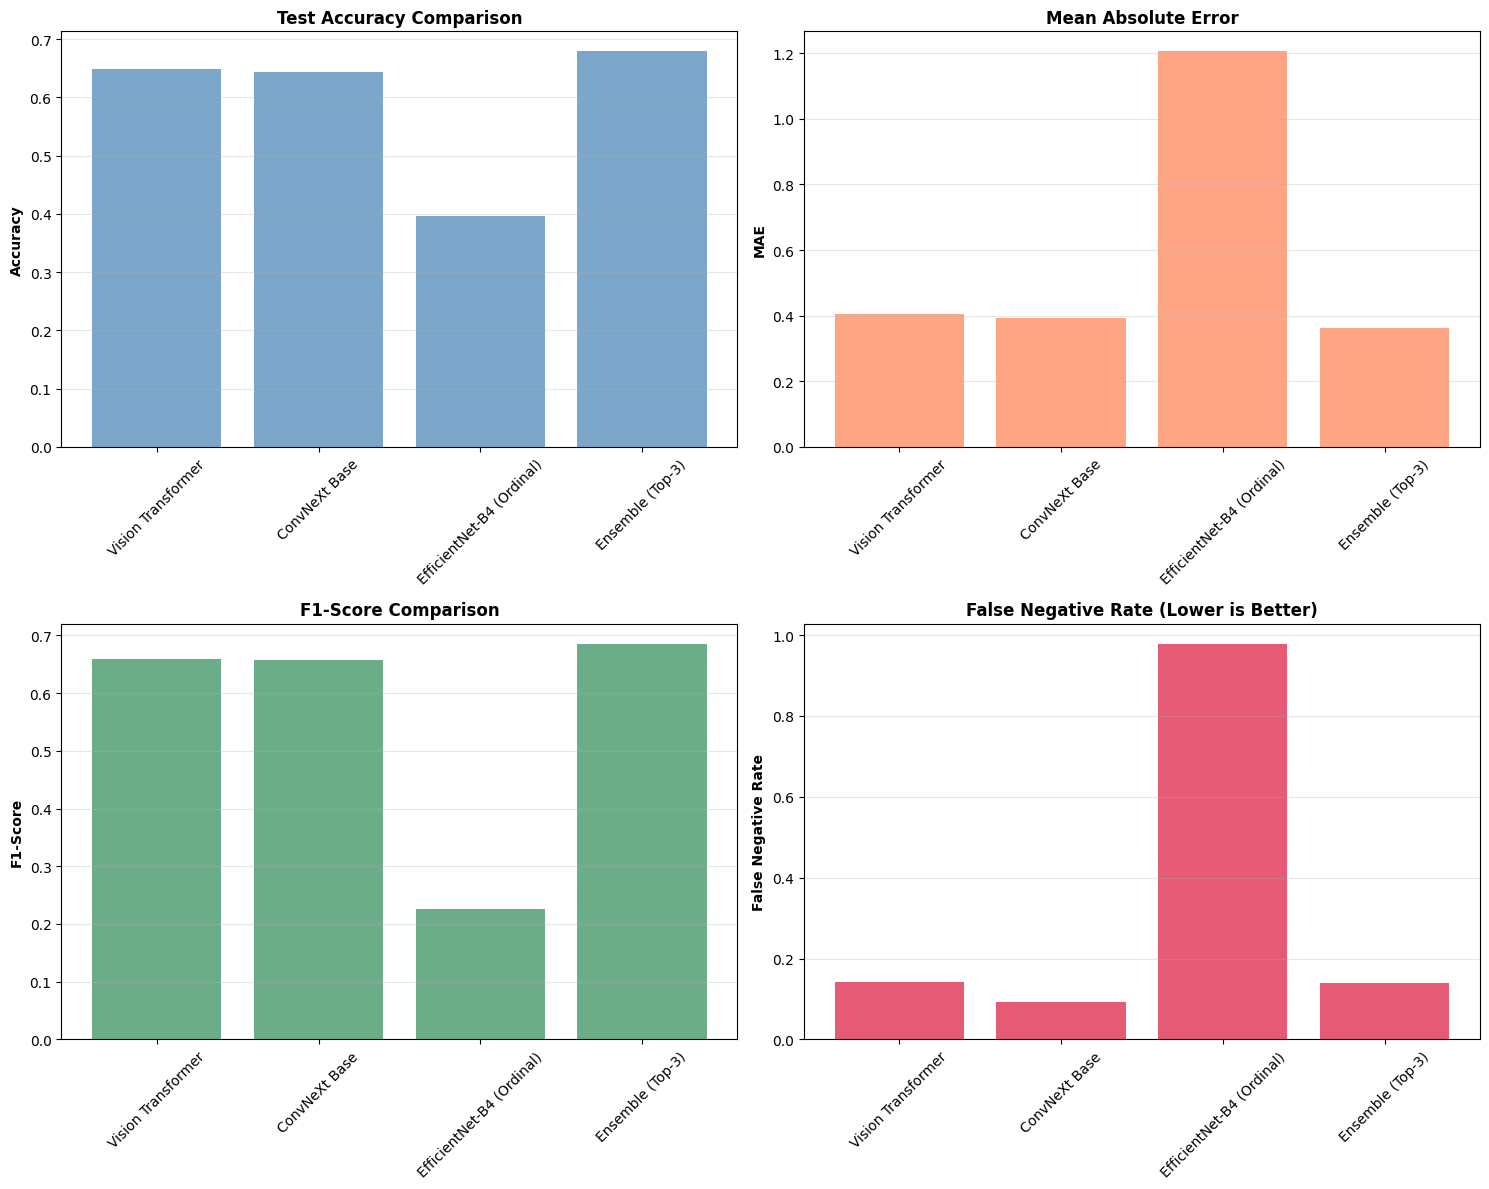

In [6]:
# Cell 6: Advanced Architecture Comparison
"""
Compare all advanced architectures
"""

results = {
    'Architecture': [
        'Vision Transformer',
        'ConvNeXt Base',
        'EfficientNet-B4 (Ordinal)',
        'Ensemble (Top-3)'
    ],
    'Test Accuracy': [
        vit_test_metrics['accuracy'],
        convnext_test_metrics['accuracy'],
        ordinal_test_metrics['accuracy'],
        ensemble_test_metrics['accuracy']
    ],
    'Test MAE': [
        vit_test_metrics['mae'],
        convnext_test_metrics['mae'],
        ordinal_test_metrics['mae'],
        ensemble_test_metrics['mae']
    ],
    'Test F1': [
        vit_test_metrics['f1'],
        convnext_test_metrics['f1'],
        ordinal_test_metrics['f1'],
        ensemble_test_metrics['f1']
    ],
    'Sensitivity': [
        vit_test_metrics['sensitivity_binary'],
        convnext_test_metrics['sensitivity_binary'],
        ordinal_test_metrics['sensitivity_binary'],
        ensemble_test_metrics['sensitivity_binary']
    ],
    'FNR': [
        vit_test_metrics['false_negative_rate'],
        convnext_test_metrics['false_negative_rate'],
        ordinal_test_metrics['false_negative_rate'],
        ensemble_test_metrics['false_negative_rate']
    ]
}

advanced_df = pd.DataFrame(results)

styled = advanced_df.style.highlight_max(subset=['Test Accuracy', 'Test F1', 'Sensitivity'], color='lightgreen') \
                          .highlight_min(subset=['Test MAE', 'FNR'], color='lightgreen') \
                          .format({'Test Accuracy': '{:.4f}', 'Test MAE': '{:.4f}', 
                                  'Test F1': '{:.4f}', 'Sensitivity': '{:.4f}', 'FNR': '{:.4f}'})
display(styled)

advanced_df.to_csv('../reports/tables/advanced_architectures_results.csv', index=False)

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Accuracy
axes[0, 0].bar(advanced_df['Architecture'], advanced_df['Test Accuracy'], color='steelblue', alpha=0.7)
axes[0, 0].set_ylabel('Accuracy', fontweight='bold')
axes[0, 0].set_title('Test Accuracy Comparison', fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# MAE
axes[0, 1].bar(advanced_df['Architecture'], advanced_df['Test MAE'], color='coral', alpha=0.7)
axes[0, 1].set_ylabel('MAE', fontweight='bold')
axes[0, 1].set_title('Mean Absolute Error', fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# F1-Score
axes[1, 0].bar(advanced_df['Architecture'], advanced_df['Test F1'], color='seagreen', alpha=0.7)
axes[1, 0].set_ylabel('F1-Score', fontweight='bold')
axes[1, 0].set_title('F1-Score Comparison', fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# FNR (lower is better)
axes[1, 1].bar(advanced_df['Architecture'], advanced_df['FNR'], color='crimson', alpha=0.7)
axes[1, 1].set_ylabel('False Negative Rate', fontweight='bold')
axes[1, 1].set_title('False Negative Rate (Lower is Better)', fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/advanced_architectures_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

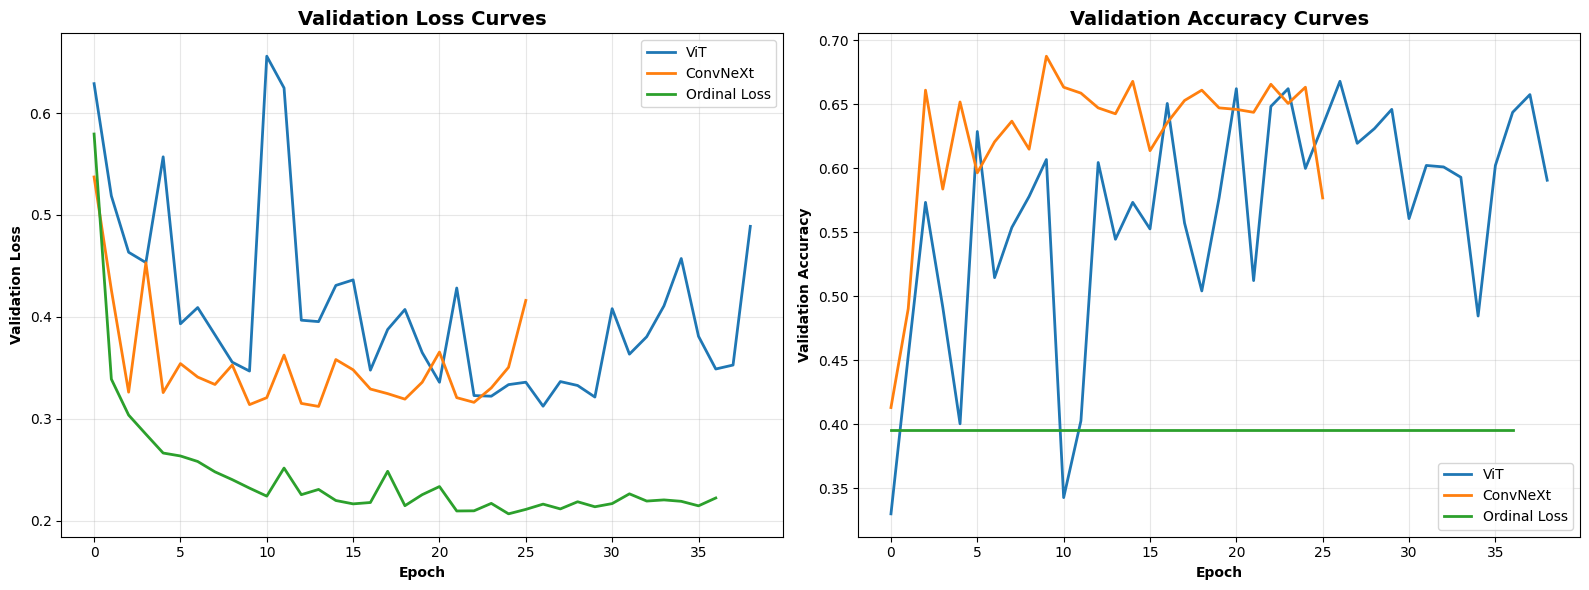


 Advanced Architecture Training Complete!


In [7]:
# Cell 7: Training Curves Comparison
"""
Compare training curves across all models
"""

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Validation Loss
axes[0].plot(vit_history['val_loss'], label='ViT', linewidth=2)
axes[0].plot(convnext_history['val_loss'], label='ConvNeXt', linewidth=2)
axes[0].plot(ordinal_history['val_loss'], label='Ordinal Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontweight='bold')
axes[0].set_ylabel('Validation Loss', fontweight='bold')
axes[0].set_title('Validation Loss Curves', fontweight='bold', fontsize=14)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Validation Accuracy
axes[1].plot(vit_history['val_acc'], label='ViT', linewidth=2)
axes[1].plot(convnext_history['val_acc'], label='ConvNeXt', linewidth=2)
axes[1].plot(ordinal_history['val_acc'], label='Ordinal Loss', linewidth=2)
axes[1].set_xlabel('Epoch', fontweight='bold')
axes[1].set_ylabel('Validation Accuracy', fontweight='bold')
axes[1].set_title('Validation Accuracy Curves', fontweight='bold', fontsize=14)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/advanced_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Advanced Architecture Training Complete!")